# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    
- 8. [Test transition path](#toc8_)    
- 9. [Find transition path](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [3]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [4]:
model = HANCWelfareModelClass(name='baseline')

In [5]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [6]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.chi = 0.0
ss.S = 0.0
ss.tau = 0.015

We can now solve and simulate:

In [7]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.9 secs [345 iterations]


/Users/nicolaibernsen/opt/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 5.4 secs [399 iterations]


And we can check whether the results make sort of sense:

In [9]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.02
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


In [10]:
# model.test_hh_path()

## 3. <a id='toc3_'></a>[Test 2: Evaluating the objective for finding the steady state](#toc0_)

We can try out various inputs and look at the outputs:

In [11]:
ss.G = 0.0
ss.LG = 0.0
ss.S = 0.0
tau=0.1
for KL in [2.0,3.0,4.0]:
    clearing_A = obj_ss(np.array([KL,tau]),model,do_print=False)
    print(f'{KL = :.2f} -> {clearing_A[0] = :12.8f}')

KL = 2.00 -> clearing_A[0] = -101.92176966
KL = 3.00 -> clearing_A[0] = -24.09232166
KL = 4.00 -> clearing_A[0] =   2.18390066


In [12]:
print(f"wage (ss.w) = {model.ss.w:.2f}")
print(f"tax rate (ss.tau) = {model.ss.tau}")
print(f"after-tax wage (ss.wt) = {model.ss.wt}")
print(f"government labor (ss.LG) = {model.ss.LG}")
print(f"government services (ss.S) = {model.ss.S}")
print(f"government spendings (ss.G) = {model.ss.G}")
print(f"firm labor (ss.LY) = {model.ss.LY}")
print(f"household labor (ss.L_hh) = {model.ss.L_hh}")
print(f"labor (ss.L) = {model.ss.L}")
print(f"Assets (ss.A) = {model.ss.A}")
print(f"Rented Capital (ss.rk) = {model.ss.rK}")
print(f"Capital (ss.K) = {model.ss.K}")
print(f"Chi (ss.chi) = {model.ss.chi}")

wage (ss.w) = 1.06
tax rate (ss.tau) = 0.1
after-tax wage (ss.wt) = 0.9549014369015507
government labor (ss.LG) = 0.0
government services (ss.S) = 0.0
government spendings (ss.G) = 0.0
firm labor (ss.LY) = 0.9388797829196087
household labor (ss.L_hh) = 0.9388797829196087
labor (ss.L) = 0.9388797829196087
Assets (ss.A) = 3.806916390290239
Rented Capital (ss.rk) = 0.11367874248827986
Capital (ss.K) = 3.755519131678435
Chi (ss.chi) = 0.0


## 4. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [13]:
model.info(only_blocks=True)

production_firm: [K] -> [LY,rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
government: [tau,w,chi] -> [B,wt,G,LG,S]
hh: [S,chi,r,tau,wt] -> [A_hh,C_hh,ELL_hh,L_hh,INC_hh,U_hh]
market_clearing: [A,A_hh,L,LY,LG,L_hh,Y,C_hh,K,G] -> [I,clearing_A,clearing_L,clearing_Y]


In [416]:
# par.Gamma_Y = 1.1
# par.chi_ss = 0.01
model.find_ss(LG=0.0,do_print=True)

starting at KL=3.8624

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.954e-14 -2.164e-15]
       x: [ 3.673e+00 -2.268e-15]
    nfev: 11
    fjac: [[-1.000e+00  4.579e-04]
           [-4.579e-04 -1.000e+00]]
       r: [-8.495e+00 -4.354e+00 -9.527e-01]
     qtf: [-1.314e-11  2.589e-12]

steady state found in 11.3 secs
ss.K =  3.389
ss.B = -0.000
ss.A_hh =  3.389
ss.L =  0.923
ss.Y =  1.363
ss.r =  0.021
ss.w =  1.034
ss.G =  0.000
ss.LG =  0.000
ss.LY =  0.923
ss.tau = -0.000
ss.chi =  0.000
ss.clearing_A = 1.95e-14
ss.clearing_L = 0.00e+00
ss.clearing_Y = 0.00e+00


In [417]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
print(f'Expected discounted utility with ss.G, ss.LG, ss.chi = 0: {V_hh_ss}')

Expected discounted utility with ss.G, ss.LG, ss.chi = 0: -2500000037.032257


In [419]:
def target(LG):
    
    model.find_ss(LG)
    return -ss.U_hh
res = optimize.minimize_scalar(target,bounds=(0.0,0.4),method='bounded',
                            options={'disp':3})
LG_max_U_hh = res.x
max_U_hh = res.fun

V_hh_ss_1 = np.sum([par.beta**t*max_U_hh for t in range(par.T)])
opt_G = par.Gamma_G*LG_max_U_hh

print(f'Optimal ss.LG to maximize expected discounted utility: {LG_max_U_hh:.4f}')
print(f'Optimal ss.G to maximize expected discounted utility: {opt_G:.4f}')
print(f'Total expected discounted utility: {V_hh_ss_1:.4f}')
print(f'G/Y: {opt_G/ss.Y:.4f}')

 
 Func-count     x          f(x)          Procedure
    1       0.152786      8.68807        initial
    2       0.247214      6.92702        golden
    3       0.305573      7.01197        golden
    4       0.270862      6.89003        parabolic
    5       0.268028      6.89122        parabolic
    6       0.273281      6.88835        parabolic
    7       0.285615      6.87548        golden
    8       0.293238      6.91266        golden
    9       0.280904      6.86093        golden
   10       0.280411      6.85976        parabolic
   11       0.277687      6.85453        golden
   12       0.276004       6.8523        golden
   13       0.274964       6.9151        golden
   14       0.276647      6.85306        golden
   15       0.275607      6.85188        golden
   16       0.275361      6.85165        golden
   17       0.275209      6.85151        golden
   18       0.275116      6.85143        golden
   19       0.275058      6.85138        golden
   20       0.275022  

In [275]:
ss.chi = 0.0001

def target(LG):
    
    model.find_ss(LG)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.0,0.4),method='bounded',
                                options={'disp':3})
LG_max_U_hh_chi_plus = res.x
max_U_hh_chi_plus = res.fun
V_hh_ss_2 = np.sum([par.beta**t*max_U_hh_chi_plus for t in range(par.T)])
opt_G = par.Gamma_G*LG_max_U_hh_chi_plus

print(f'Optimal ss.LG to maximize expected discounted utility: {LG_max_U_hh_chi_plus:.4f}')
print(f'Optimal ss.G to maximize expected discounted utility: {opt_G:.4f}')
print(f'Total expected discounted utility: {V_hh_ss_2:.4f}')
print(f'G/Y: {opt_G/ss.Y:.4f}')

 
 Func-count     x          f(x)          Procedure
    1       0.357105      4.56047        initial
    2       0.577808      3.49724        golden
    3       0.714209      3.16252        golden
    4       0.831397      2.94388        parabolic
    5       0.786635       3.0243        golden
    6       0.870936      2.86698        golden
    7       0.895373      2.77475        golden
    8       0.910476       5.6081        golden
    9       0.886039      2.82751        golden
   10       0.901142      3.47653        golden
   11       0.891808      2.80505        golden
   12       0.897577      3.05202        golden
   13       0.894011      2.79184        golden
   14       0.896215      2.84314        golden
   15       0.894853      2.78399        golden
   16       0.895695      2.79295        golden
   17       0.895174      2.77943        golden
   18       0.895496      2.77586        golden
   19        0.89539      2.77411        parabolic
   20       0.895424      2.

In [278]:
ss.chi = -0.001

def target(LG):
    
    model.find_ss(LG)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.0,ss.L_hh),method='bounded',
                                options={'disp':True})
LG_max_U_hh_chi_minus = res.x
max_U_hh_chi_minus = res.fun
V_hh_ss_3 = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
opt_G = par.Gamma_G*LG_max_U_hh_chi_minus

print(f'Optimal ss.LG to maximize expected discounted utility: {LG_max_U_hh_chi_minus:.4f}')
print(f'Optimal ss.G to maximize expected discounted utility: {opt_G:.4f}')
print(f'Total expected discounted utility: {V_hh_ss_3:.4f}')
print(f'G/Y: {opt_G/ss.Y:.4f}')

 
 Func-count     x          f(x)          Procedure
    1       0.347054      4.64048        initial
    2       0.561546      3.54768        golden
    3       0.694108      3.20483        golden
    4       0.806725       2.9885        parabolic
    5       0.763709      3.06667        golden
    6       0.845638      2.91803        golden
    7       0.869687      2.87012        golden
    8        0.88455      2.83242        golden
    9       0.893736      2.79437        golden


/Users/nicolaibernsen/Documents/KU/11.semester/HANK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:103: RuntimeWarning: invalid value encountered in scalar power
  ss.Y = par.Gamma_Y*ss.K**(par.alpha)*ss.LY**(1-par.alpha)


   10       0.899414      3.19982        golden
   11       0.890228      2.81252        golden
   12       0.895905       2.8073        golden
   13       0.893301      2.79724        parabolic
   14       0.894201      2.79093        parabolic
   15       0.894852      2.78488        golden
   16       0.895254      2.77939        golden
   17       0.895503      2.77232        golden
   18       0.895656      2.78288        golden
   19       0.895437      2.77524        parabolic
   20       0.895561       2.7734        golden
   21       0.895514      2.77121        parabolic
   22       0.895528      2.77107        parabolic
   23       0.895541      2.77242        golden
   24       0.895523      2.77057        parabolic
   25       0.895519      2.77023        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


In [288]:
# Update the model for increased TFP
par.Gamma_Y = 1.1

# Define a function to optimize LG for given chi
def target(LG, chi, model):
    model.ss.chi = chi  
    model.find_ss(LG)
    return -model.ss.U_hh

# Define chi values to test, ensuring they are floating-point numbers
chi_values = [-0.1, 0.0, 0.1]

# Initialize dictionary to store results
results = {}

# Run optimization for each chi value
for chi in chi_values:
    res = optimize.minimize_scalar(target, bounds=(0.5, model.ss.L_hh), args=(chi, model), method='bounded', options={'disp':True})
    LG_max_U_hh = res.x
    max_U_hh = -res.fun  # Negate since we minimized the negative utility
    results[chi] = {'LG_max_U_hh': LG_max_U_hh, 'max_U_hh': max_U_hh}

# Print or process the results as needed
for chi, result in results.items():
    print(f"For chi = {chi}: Optimal LG = {result['LG_max_U_hh']}, Max Utility = {result['max_U_hh']}")


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


ValueError: solve_hh_ss(), too many iterations

In [423]:
jump = ss.chi*0.01
rho = 0.95
dchi = jump*rho**np.arange(par.T)

In [425]:
model.find_transition_path(shocks={'dchi':dchi},do_print=True)
path = model.path

finding the transition path:
 it =   0 -> max. abs. error = 7.52e-03
   7.52e-03 in clearing_A
   1.98e-10 in clearing_L


LinAlgError: Last 2 dimensions of the array must be square

### shocks ###


/Users/nicolaibernsen/Documents/KU/11.semester/HANK/GEModelTools/GEModelTools/figures.py:107: RuntimeWarning: invalid value encountered in divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


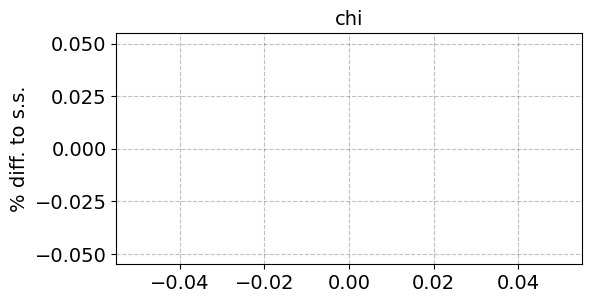


### varnames ###


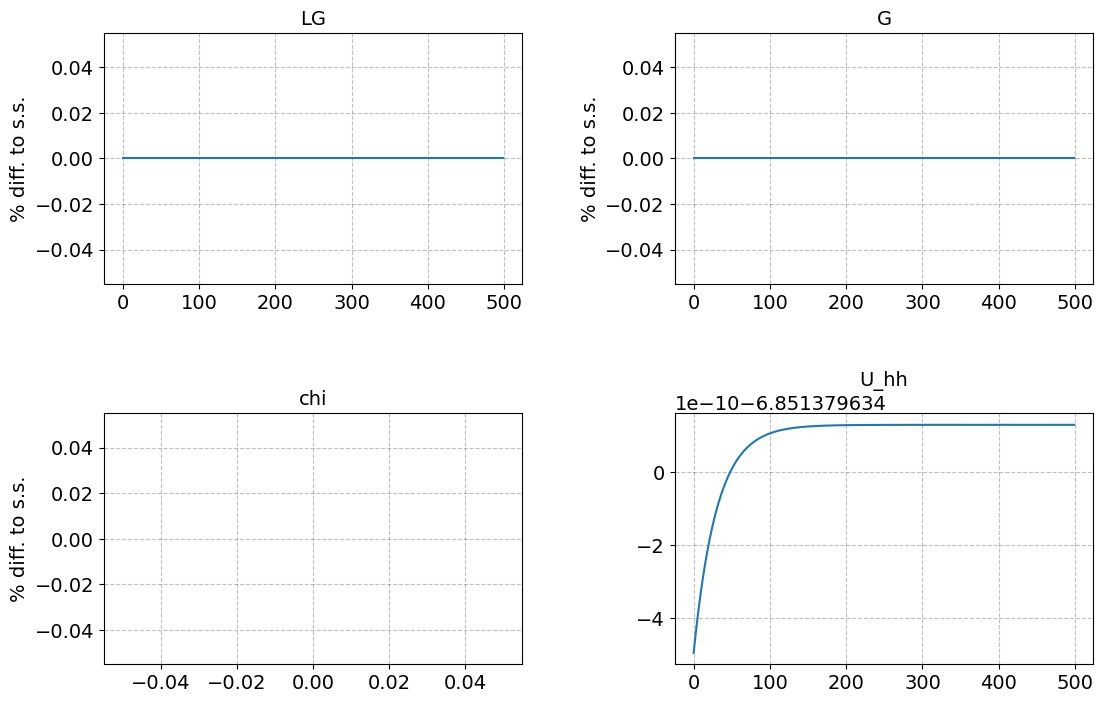


### tagets ###


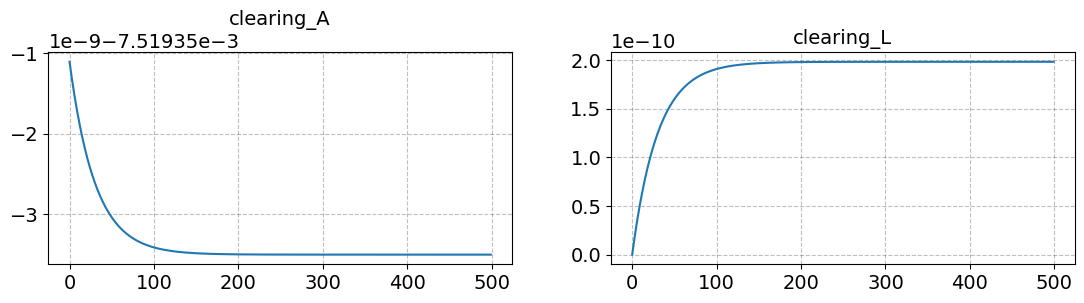

In [426]:
model.show_IRFs(varnames=['LG','G','chi','U_hh'],lvl_value=['U_hh'],ncols=2)

In [430]:
model.compute_jacs()

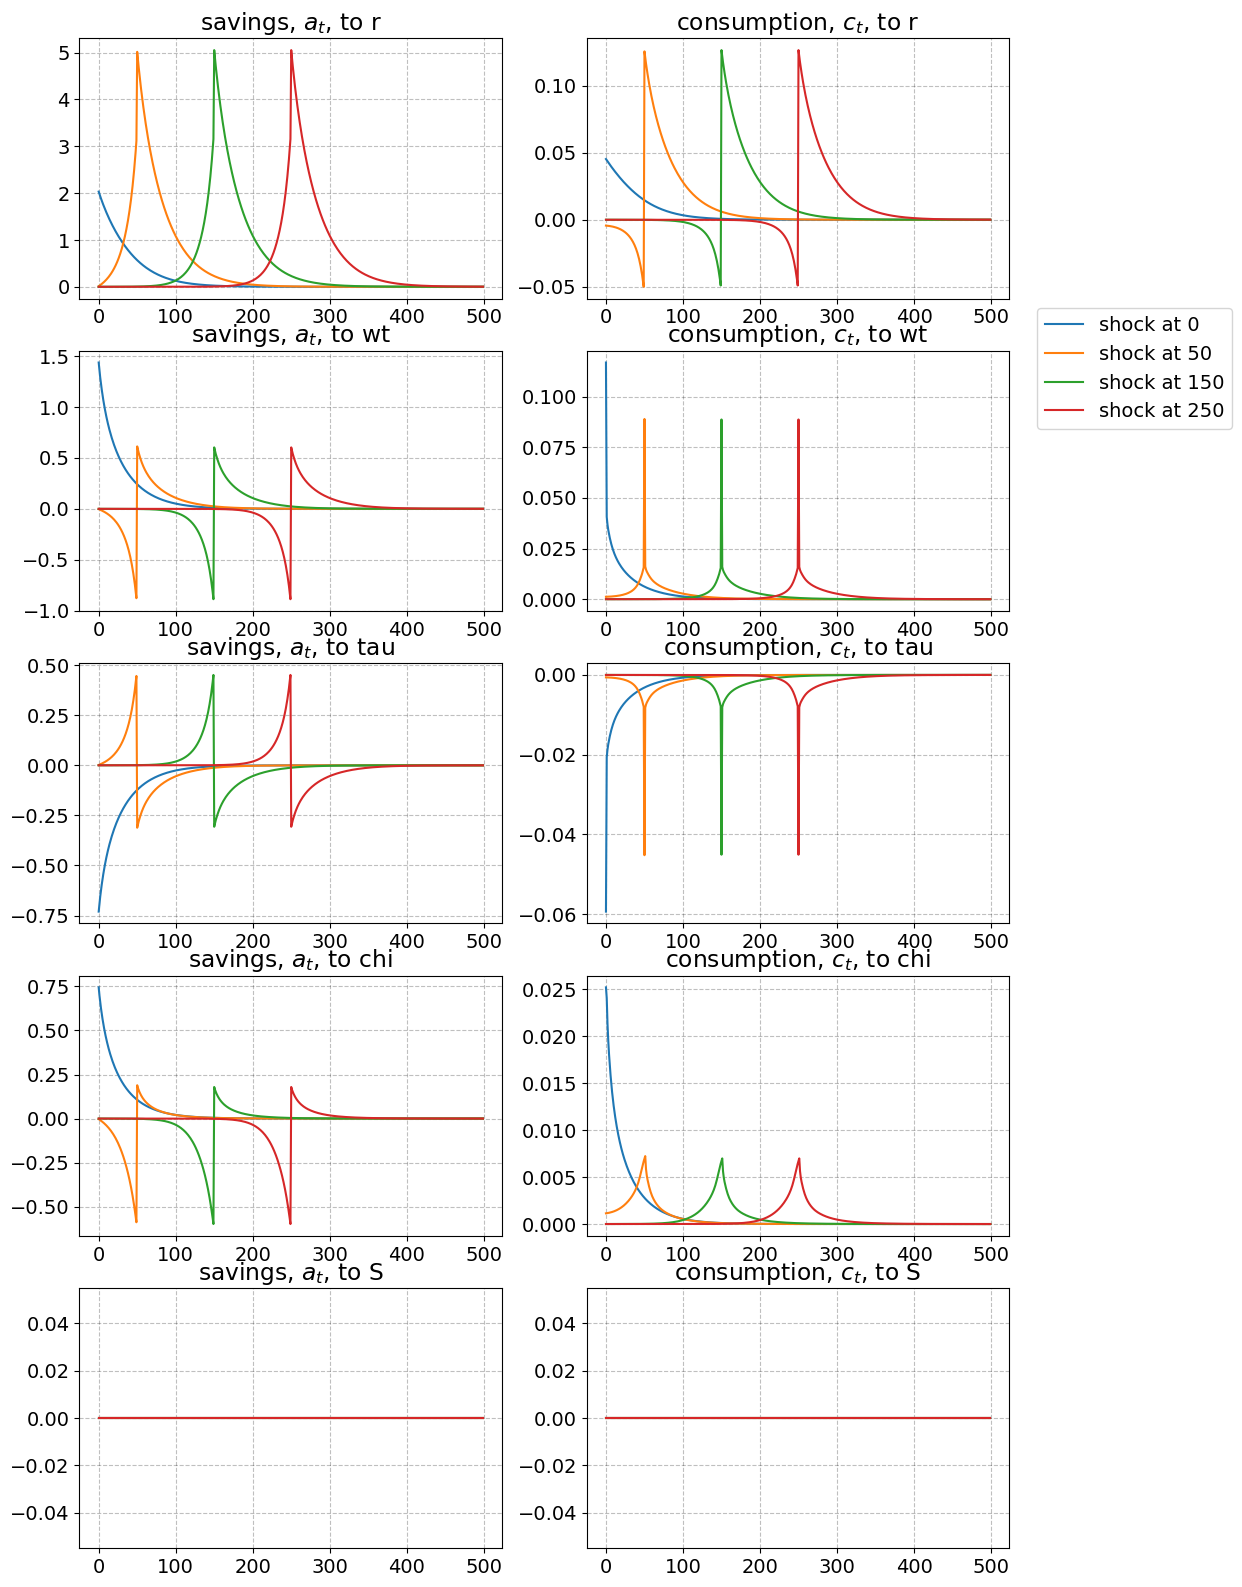

In [434]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
        
plt.show()

In [436]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

In [ ]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['Gamma_Y'],['chi'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

## 5. <a id='toc5_'></a>[Grid search](#toc0_)

In [213]:
par.tau_ss = 0.0
KL_min = ((1/par.beta+par.delta-1)/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))
KL_max = (par.delta/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))

In [215]:
NKL = 10
KL_vec = np.hstack((np.linspace(KL_min+1e-2,KL_max-1e-2,NKL),np.linspace(KL_max+1e-2,10.0,NKL)))
clearing_A_vec = np.nan*np.ones(KL_vec.size)
r_vec = np.nan*np.ones(KL_vec.size)

model_ = model.copy()
for i,KL in enumerate(KL_vec):
    print(f'{KL = :6.2f}: ',end='')
    try:
        clearing_A_vec[i] = obj_ss(np.array([KL,0.2]),model_,do_print=False)
        r_vec[i] = model_.ss.r
        print(f'clearing_A = {clearing_A_vec[i]:16.8f}')
    except Exception as e:
        print(e)

KL =   2.93: 

/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:82: RuntimeWarning: invalid value encountered in double_scalars
  ss.Y = par.Gamma_Y*ss.K**(par.alpha)*ss.LY**(1-par.alpha)


setting an array element with a sequence.
KL =   3.14: setting an array element with a sequence.
KL =   3.34: setting an array element with a sequence.
KL =   3.55: setting an array element with a sequence.
KL =   3.76: setting an array element with a sequence.
KL =   3.97: setting an array element with a sequence.
KL =   4.17: setting an array element with a sequence.
KL =   4.38: setting an array element with a sequence.
KL =   4.59: setting an array element with a sequence.
KL =   4.79: setting an array element with a sequence.
KL =   4.81: setting an array element with a sequence.
KL =   5.39: setting an array element with a sequence.
KL =   5.97: setting an array element with a sequence.
KL =   6.54: setting an array element with a sequence.
KL =   7.12: setting an array element with a sequence.
KL =   7.70: setting an array element with a sequence.
KL =   8.27: setting an array element with a sequence.
KL =   8.85: setting an array element with a sequence.
KL =   9.42: setting an

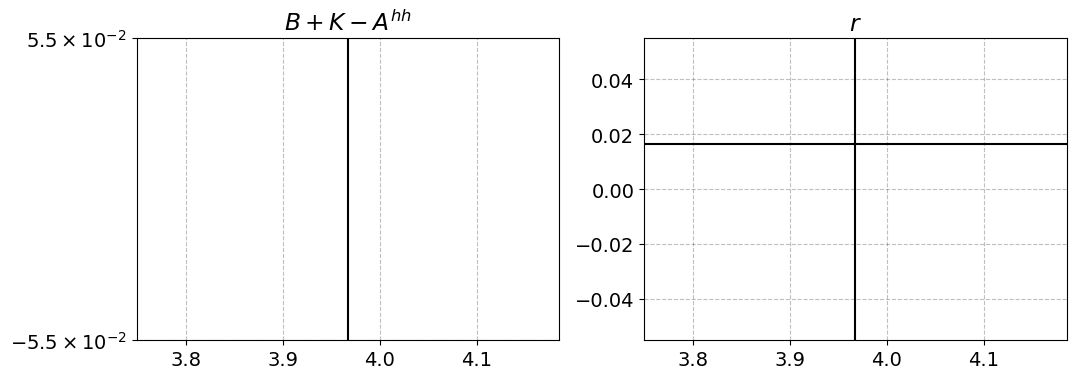

In [216]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('$B+K-A^{hh}$')
ax.plot(KL_vec[:NKL],clearing_A_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],clearing_A_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black')
ax.set_yscale('symlog')

ax = fig.add_subplot(1,2,2)
ax.set_title('$r$')
ax.plot(KL_vec[:NKL],r_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],r_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black');
ax.axhline(ss.r,color='black');

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

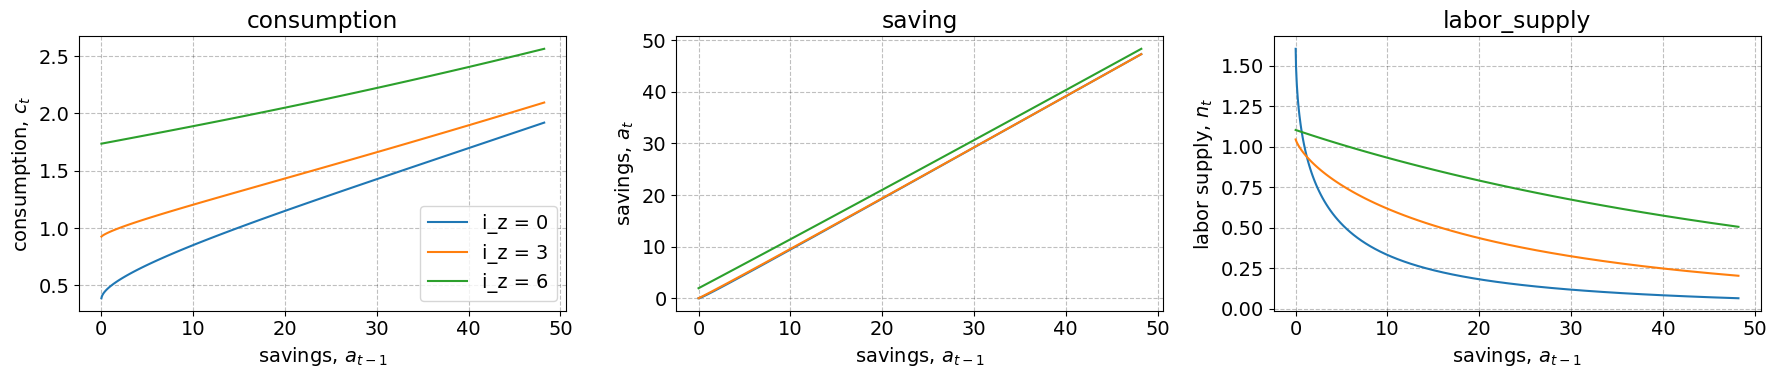

In [14]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()

## 7. <a id='toc7_'></a>[Simulation](#toc0_)

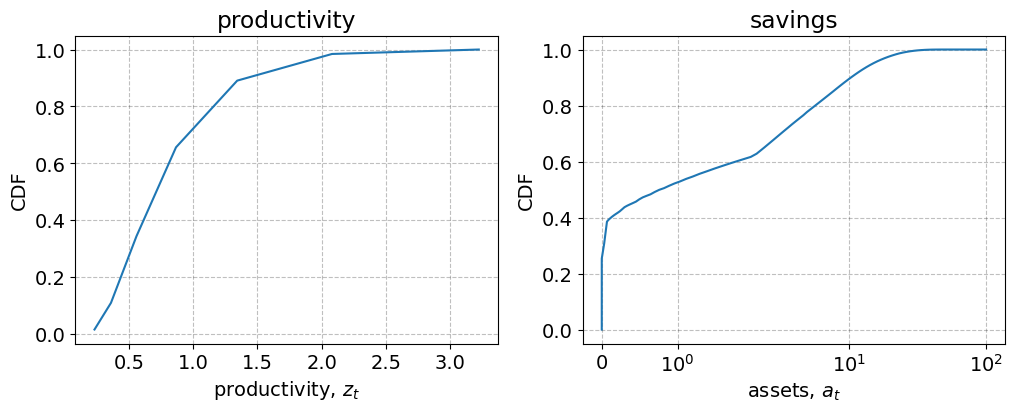

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 8. <a id='toc8_'></a>[Test transition path](#toc0_)

In [214]:
try:
    model.test_ss()
except Exception as e:
    print('you need to update GEModelTools to call this function (optional)')

you need to update GEModelTools to call this function (optional)


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.8 secs
household problem simulated along transition in 0.2 secs



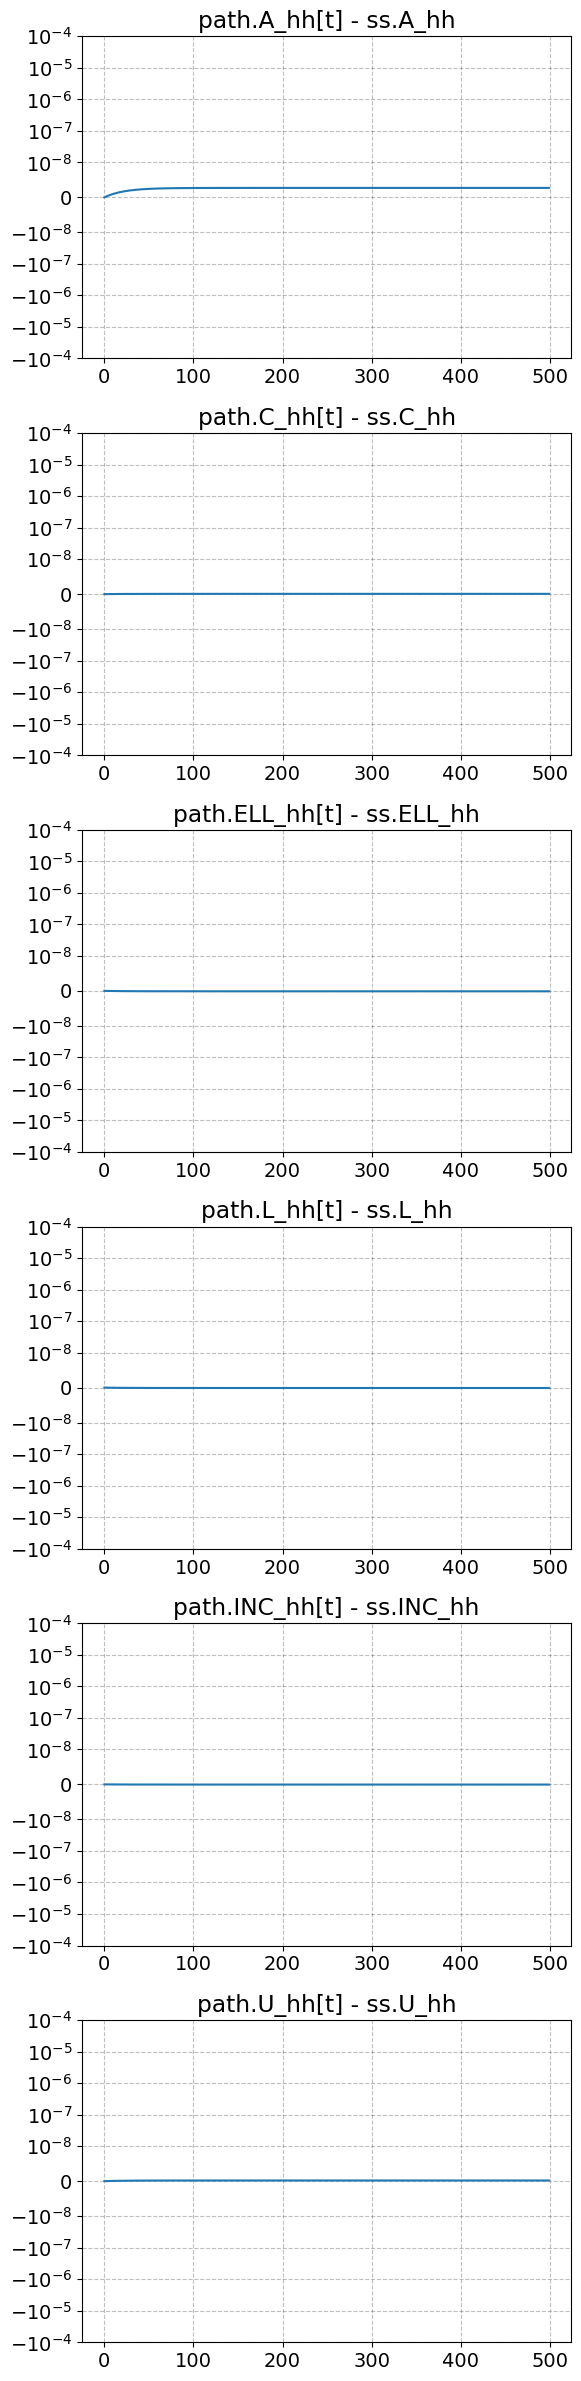

In [17]:
model.test_hh_path()

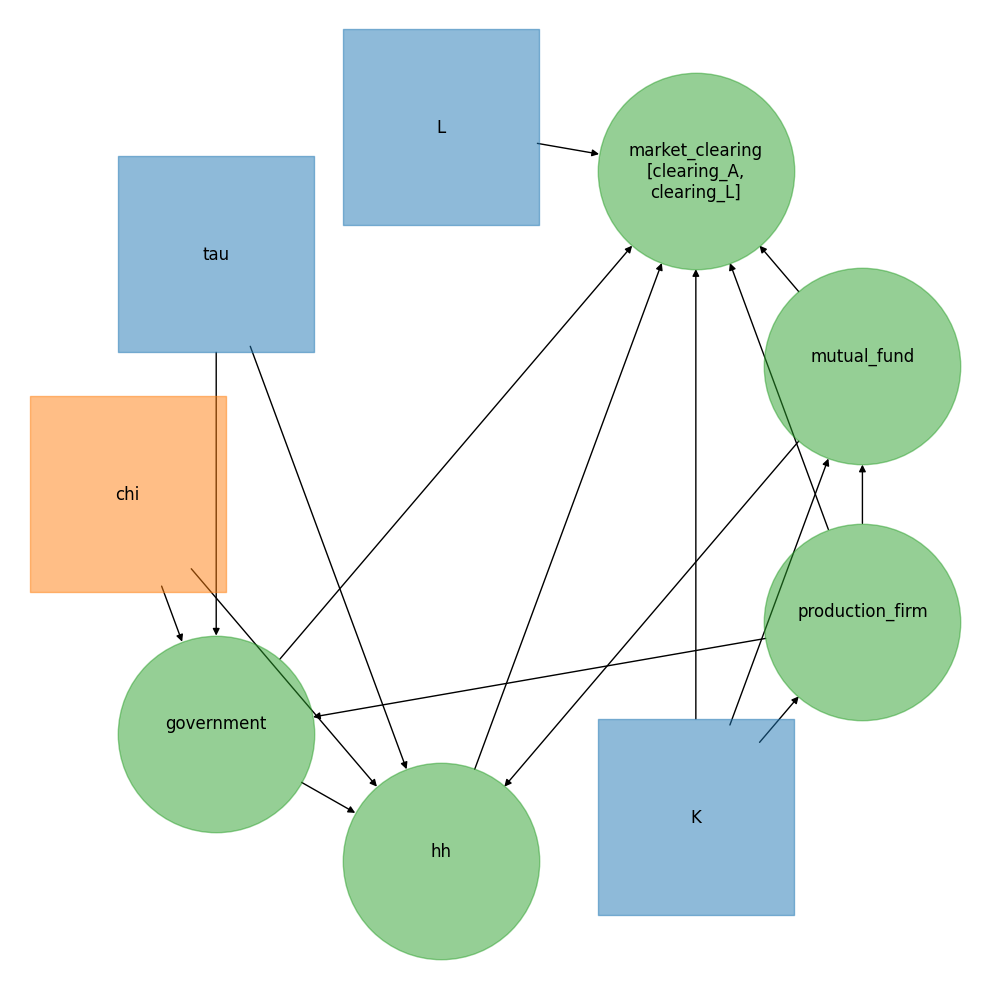

In [215]:
model.draw_DAG()

In [243]:
model.test_path(in_place=True)

shocks: chi 
unknowns: K L tau 

blocks.production_firm
 LY               0.0e+00
 rK               2.6e-05
 w                1.0e-04
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                2.6e-05
blocks.government
 B                0.0e+00
 wt               9.1e-05
 G                0.0e+00
 LG               0.0e+00
 S                0.0e+00
hh
 A_hh             2.1e+00
 C_hh             6.3e-01
 ELL_hh           9.3e-02
 L_hh             1.2e-01
 INC_hh           7.1e-02
 U_hh             1.4e-01
blocks.market_clearing
 I                1.1e-16
 clearing_A       2.1e+00 [target]
 clearing_L       1.2e-01 [target]
 clearing_Y       6.3e-01


## 9. <a id='toc9_'></a>[Find transition path](#toc0_)

In [244]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for S               in 1.6 secs
curly_Y and curly_D calculated for chi             in 1.5 secs
curly_Y and curly_D calculated for r               in 1.5 secs
curly_Y and curly_D calculated for tau             in 1.5 secs
curly_Y and curly_D calculated for wt              in 1.6 secs
curly_E calculated in 2.5 secs
builiding blocks combined in 0.9 secs
household Jacobian computed in 11.0 secs

full Jacobians:
full Jacobian to unknowns computed in 1.5 secs [in evaluate_blocks(): 0.7 secs]
full Jacobian to shocks computed in 0.4 secs [in evaluate_blocks(): 0.2 secs]


In [245]:
model.find_transition_path(shocks=[],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.09e+00
   2.09e+00 in clearing_A
   1.16e-01 in clearing_L


LinAlgError: Last 2 dimensions of the array must be square